In [1]:
from tqdm import tqdm
import pickle
from time import time

import numpy as np
import scipy as scipy

import matplotlib.pyplot as plt

# Isoscelese triangle

In [3]:
def build_A_b(eps):
    A = np.array([[0., 1.], [1, eps**2], [-1, eps**2]])
    b = np.array([0., eps, eps])
    return A,b

In [4]:
def get_example(eps,lamb):
    A,b = build_A_b(eps)
    x_ls = np.linalg.lstsq(A,b, rcond=None)[0]
    r = A @ x_ls -  b

    W = np.zeros((3,3))
    V = 0.

    I3 = np.eye(3)
    I2 = np.eye(2)
    
    for (i,j) in ([0,1],[0,2],[1,2]):
        AS = A[[i,j],:]
        IS = I3[[i,j],:]
        rS = r[[i,j]]

        W += IS.T @ np.linalg.solve(AS @ AS.T + lamb * 3 * I2, IS)

    x_rho = np.linalg.solve(A.T @ W @ A, A.T @ W @ b)
    return A, b, x_ls, x_rho

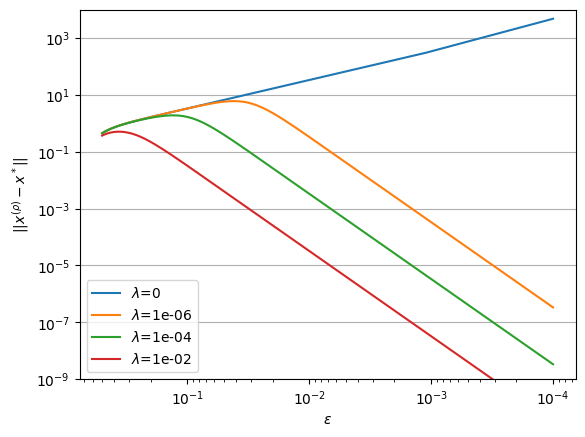

In [5]:
eps_vals = np.linspace(1e-4, 0.5, 500)

fig, ax = plt.subplots()

for lamb in [0., 1e-6, 1e-4, 1e-2]:
    biases = []
    
    for eps in eps_vals:
        A, b, x_ls, x_rho = get_example(eps, lamb)
        biases.append(np.linalg.norm(x_ls - x_rho))

    lambda_string = f'{lamb:.0e}' if lamb > 0 else "0"

    ax.plot(eps_vals, biases, label=r'$\lambda$=' + lambda_string)
    ax.set_yscale('log')
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(r"$||x^{(\rho)} - x^*||$")
    ax.set_xscale('log')
    ax.set_ylim([1e-9, 1e4])
    ax.xaxis.set_inverted(True)
    ax.legend(loc='lower left')
    
ax.grid(axis='y')
plt.savefig("epsilons.pdf", bbox_inches='tight')

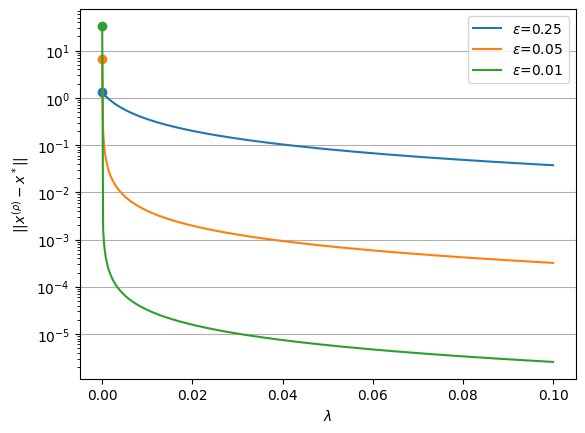

In [6]:
lamb_vals = np.linspace(0., 0.1, 500)

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green']
eps_vals = [0.25, 0.05, 0.01]

for (eps, color) in zip(eps_vals, colors):
    biases = []
    
    for lamb in lamb_vals:
        A, b, x_ls, x_rho = get_example(eps, lamb)
        biases.append(np.linalg.norm(x_ls - x_rho))

    ax.plot(lamb_vals[0], biases[0], marker='o')
    ax.plot(lamb_vals, biases,label=rf'$\epsilon$={eps}',color=color)
    ax.set_yscale('log')
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel(r"$||x^{(\rho)} - x^*||$")
    ax.legend(loc='upper right')
    
ax.grid(axis='y')
plt.savefig("lambdas.pdf", bbox_inches='tight')

# Algorithms and helper functions

In [2]:
def get_rbk_step():
    def rbk_step(x, AS, bS):
        return x + np.linalg.lstsq(AS, bS - AS @ x, rcond=None)[0]

    return rbk_step


def get_reblock_step(lamb=0.001):
    def reblock_step(x, AS, bS):
        k = AS.shape[0]
        return x + AS.T @ scipy.linalg.solve(AS @ AS.T + lamb * k * np.eye(k), bS - AS @ x, assume_a='pos')

    return reblock_step
    

def get_minibatch_sgd_step(m, gamma=0.01):
    def minibatch_sgd_step(x, AS, bS):
        k = AS.shape[0]
        return x + gamma * AS.T @ (bS - AS @ x) / k

    return minibatch_sgd_step

In [3]:
def block_kaczmarz(A, b, k, T, take_step):
    m,n = A.shape
    x_kaczmarz = np.zeros(A.shape[1])
    xs = np.zeros((T+1, n))
    xs[0,:] = x_kaczmarz

    for t in tqdm(range(T)):
        S = np.random.choice(np.arange(m), size=k, replace=False)
        
        AS = A[S,:]
        bS = b[S]

        x_kaczmarz = take_step(x_kaczmarz, AS, bS)
        xs[t+1,:] = x_kaczmarz

    return xs

In [141]:
def plot_errs(data_list, Tburn, A, b, x_ls, color_map={}):
    fig, ax = plt.subplots()

    opt = A @ x_ls - b
    x_norm = np.linalg.norm(x_ls)
    i = 0
    
    for (xs, label, style) in data_list:
        T = xs.shape[0] - 1

        # Create single array of individual iterates and then averaged iterates
        x_means = np.zeros_like(xs)
        x_means[0:Tburn,:] = xs[0:Tburn,:]
        x_means[Tburn:,:] = np.cumsum(xs[Tburn:,:],axis=0) / np.expand_dims(np.arange(1, T - Tburn + 2), 1)

        # Calculate errors
        err_vecs = x_means - x_ls
        errs = np.linalg.norm(err_vecs, axis=-1) / x_norm

        if label in color_map:
            ax.plot(errs, color=color_map[label], label=label, linestyle=style, linewidth=3)
        else:
            ax.plot(errs, label=label, linestyle=style, linewidth=3)

    if Tburn < T:
        ax.axvline(Tburn, color='black', dashes=[2,4], linewidth=0.5)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations')
    ax.set_ylabel(r'$||x - x^*||$ / $||x^*||$')
    ax.legend(loc='upper right')
    ax.grid(axis='y')

    return fig, ax

In [161]:
m=100000
n=100
noise_level=0.01

T = 10**5
k = 30

# RBK with Gaussian data

## Isotropic Gaussian problem

In [162]:
np.random.seed(0) 

# Generate random isotropic Gaussian problem
A = np.random.randn(m,n)

y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b, rcond=None)[0]

In [163]:
np.linalg.cond(A)

1.063635491810552

In [164]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=0.2))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:47<00:00, 348.18it/s]


100%|██████████| 10000/10000 [00:36<00:00, 273.52it/s]


In [165]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:15<00:00, 317.38it/s]


In [173]:
np.savez('data/gaussian.npz', A=A, b=b, x_sgd=x_sgd, x_rbk=x_rbk)

In [251]:
data = np.load('data/gaussian.npz')
A = data['A']
b = data['b']
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
x_sgd = data['x_sgd']
x_rbk = data['x_rbk']

In [252]:
x_data = [x_sgd, x_rbk ]
labels = ['TA-mSGD', "TA-RBK-U"]
styles = ['dashed', 'solid']
Tburn = 300

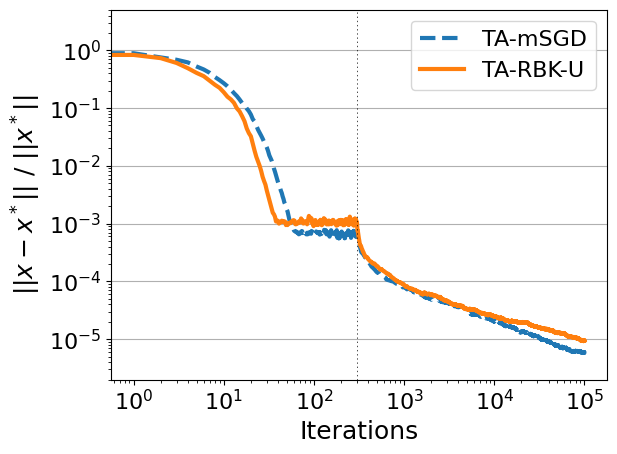

In [253]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels,styles), Tburn, A, b, x_ls)
ax.set_ylim([2e-6, 5])
plt.savefig("isotropic_gaussian.pdf", bbox_inches='tight')

In [254]:
def plot_Tburns(data_list, A, b, x_ls, color_map={}):
    fig, ax = plt.subplots()

    opt = A @ x_ls - b
    x_norm = np.linalg.norm(x_ls)
    
    i = 0
    
    for (xs, label, style, Tburn) in data_list:
        T = xs.shape[0] - 1

        # Create single array of individual iterates and then averaged iterates
        x_means = np.zeros_like(xs)
        x_means[0:Tburn,:] = xs[0:Tburn,:]
        x_means[Tburn:,:] = np.cumsum(xs[Tburn:,:],axis=0) / np.expand_dims(np.arange(1, T - Tburn + 2), 1)

        # Calculate errors
        err_vecs = x_means - x_ls
        errs = np.linalg.norm(err_vecs, axis=-1) / x_norm

        ax.axvline(Tburn, color='black', dashes=[2,4], linewidth=0.5)

        if label in color_map:
            ax.plot(errs, color=color_map[label], label=label, linestyle=style, linewidth=3)
        else:
            ax.plot(errs, label=label, linestyle=style, linewidth=3)


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations')
    ax.set_ylabel(r'$||x - x^*||$ / $||x^*||$')
    ax.legend(loc='upper right')
    ax.grid(axis='y')

    return fig, ax

In [263]:
x_data = [x_rbk, x_rbk, x_rbk ]
labels = ['$T_b=10$', "$T_b=300$", "$T_b=10,000$"]
styles = ['dashed', 'solid', 'dashdot']
Tburns = [10, 300, 10000]
color_map = {'$T_b=10$': 'orange', '$T_b=300$': 'orange', '$T_b=10,000$': 'orange'}

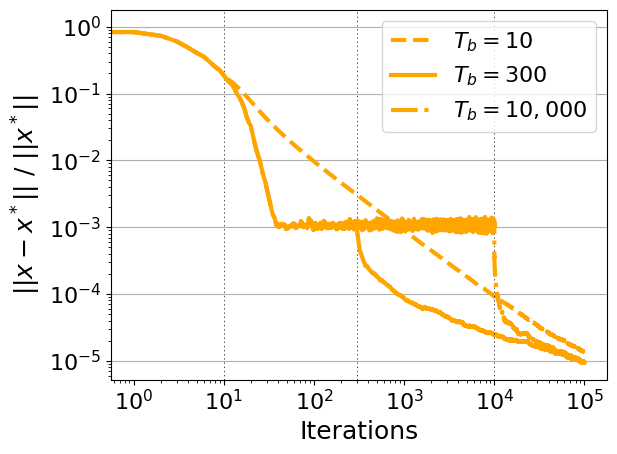

In [264]:
fig, ax = plot_Tburns(zip(x_data, labels,styles, Tburns), A, b, x_ls, color_map=color_map)
plt.savefig("Tburns.pdf", bbox_inches='tight')

## Gaussian problem with decaying singular values

In [195]:
np.random.seed(0) 

# Generate random Gaussian problem with singular value d ecay
M = np.random.randn(n, n)
Q1,_ = np.linalg.qr(M)
M = np.random.randn(n, n)
Q2,_ = np.linalg.qr(M)
U = Q1 @ np.diag(1 / np.arange(1,n+1)**2) @ Q2.T

A = np.random.randn(m,n) @ U

y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [196]:
np.linalg.cond(A)

10012.96504123611

In [197]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=1.0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:44<00:00, 351.88it/s]


In [198]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:53<00:00, 341.04it/s]


In [199]:
np.savez('data/decay_gaussian.npz', A=A, b=b, x_sgd=x_sgd, x_rbk=x_rbk)

In [218]:
data = np.load('data/decay_gaussian.npz')
A = data['A']
b = data['b']
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
x_sgd = data['x_sgd']
x_rbk = data['x_rbk']

In [219]:
x_data = [x_sgd, x_rbk ]
labels = ['TA-mSGD', "TA-RBK-U"]
styles = ['dashed', 'solid']
Tburn = 300

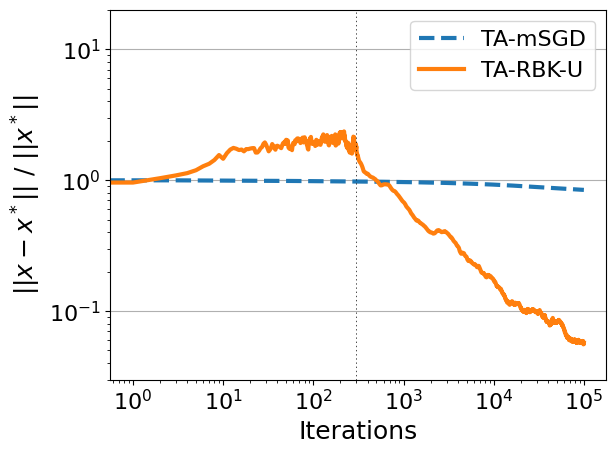

In [220]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.set_ylim([3e-2, 2e1])
plt.savefig("decay_gaussian.pdf", bbox_inches='tight')

# Problems with ill-conditioned blocks

In [122]:
lamb = 0.001

## Mild singular value decay

In [123]:
np.random.seed(0) 

# Rows correspond to values in [-1,1] 
# Columns correspond to Chebyshev polynomials
cheb_inputs = np.linspace(-1, 1, m)
cheb_coeffs = np.eye(n)
cols = []

for i in range(n):
    ci_fn = np.polynomial.chebyshev.Chebyshev(cheb_coeffs[i,:])
    cols.append(ci_fn(cheb_inputs))

A = np.stack(cols, axis=-1)

y = np.random.randn(n)

b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [124]:
np.linalg.cond(A)

11.055411653797583

In [125]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=0.5))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:08<00:00, 323.92it/s]


In [126]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:01<00:00, 332.19it/s]


In [127]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:51<00:00, 431.64it/s]


In [128]:
np.savez('data/chebyshev_mild_decay.npz', A=A, b=b, x_sgd=x_sgd, x_rbk=x_rbk, x_reblock=x_reblock)

In [221]:
data = np.load('data/chebyshev_mild_decay.npz')
A = data['A']
b = data['b']
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
x_sgd = data['x_sgd']
x_rbk = data['x_rbk']
x_reblock = data['x_reblock']

In [224]:
x_data = [x_sgd, x_rbk]
labels = ['TA-mSGD', "TA-RBK-U"]
styles = ['dashed', 'solid']
Tburn = 2000

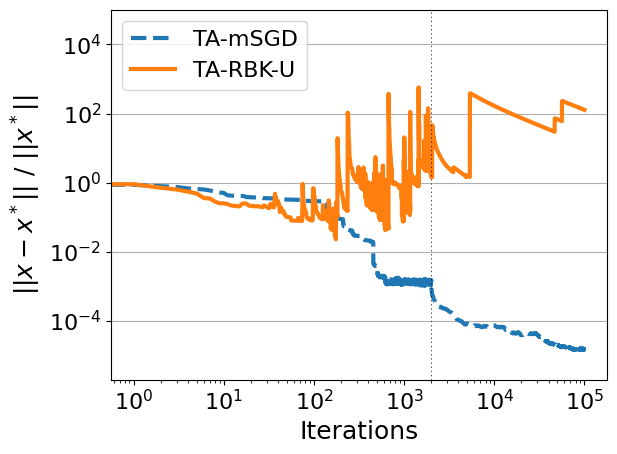

In [225]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.set_ylim([2e-6, 1e5])

ax.legend(loc='upper left')
plt.savefig("rbk_fail_mild.pdf", bbox_inches='tight')

In [226]:
x_data = [x_sgd, x_reblock]
labels = ['TA-mSGD', "TA-ReBlocK-U"]
styles = ['dashed', 'solid']
Tburn = 2000

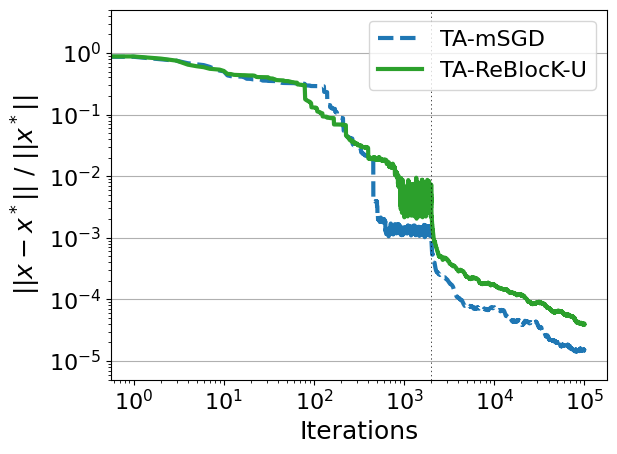

In [227]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls, color_map={"TA-ReBlocK-U": "tab:green"})
ax.set_ylim([5e-6, 5])

ax.legend(loc='upper right')
plt.savefig("reblock_succeed_mild.pdf", bbox_inches='tight')

## Rapid singular value decay

In [27]:
np.random.seed(0) 

# Rows correspond to values in [-1,1] 
# Columns correspond to linear combinations of Chebyshev polynomials
cheb_inputs = np.linspace(-1, 1, m)
    
M = np.random.randn(n, n)


U,_ = np.linalg.qr(M)
M = np.random.randn(n, n)
V,_ = np.linalg.qr(M)
S =  1 / (np.arange(n) + 1) ** 1
cheb_coeffs = U @ np.diag(S) @ V

cols = []

for i in range(n):
    ci_fn = np.polynomial.chebyshev.Chebyshev(cheb_coeffs[i,:])
    cols.append(ci_fn(cheb_inputs))

A = np.stack(cols, axis=-1)

y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [28]:
np.linalg.cond(A)

442.48567992279123

In [30]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|███████████████████████████████████████████████████████| 100000/100000 [04:17<00:00, 387.90it/s]


In [31]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:00<00:00, 415.54it/s]


In [32]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:38<00:00, 295.20it/s]


In [114]:
np.savez('data/chebyshev_fast_decay.npz', A=A, b=b, x_sgd=x_sgd, x_rbk=x_rbk, x_reblock=x_reblock)

In [228]:
data = np.load('data/chebyshev_bit_fast_decay.npz')
A = data['A']
b = data['b']
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
x_sgd = data['x_sgd']
x_rbk = data['x_rbk']
x_reblock = data['x_reblock']

In [229]:
x_sgd.shape

(100001, 100)

In [230]:
x_sgd.shape

(100001, 100)

In [239]:
x_data = [x_sgd, x_rbk]
labels = ['TA-mSGD', "TA-RBK-U"]
styles = ['dashed', 'solid']
Tburn = 10000

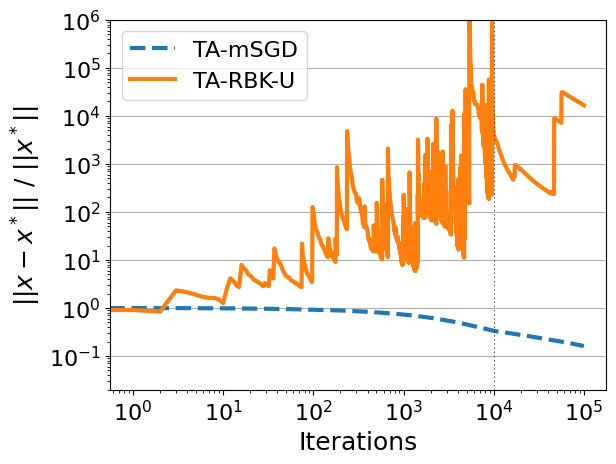

In [240]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.set_ylim([2e-2, 1e6])

ax.legend(loc='upper left')
plt.savefig("rbk_fail_fast.pdf", bbox_inches='tight')

In [242]:
x_data = [x_sgd, x_reblock]
labels = ['TA-mSGD', "TA-ReBlocK-U"]
styles = ['dashed', 'solid']
Tburn = 10000

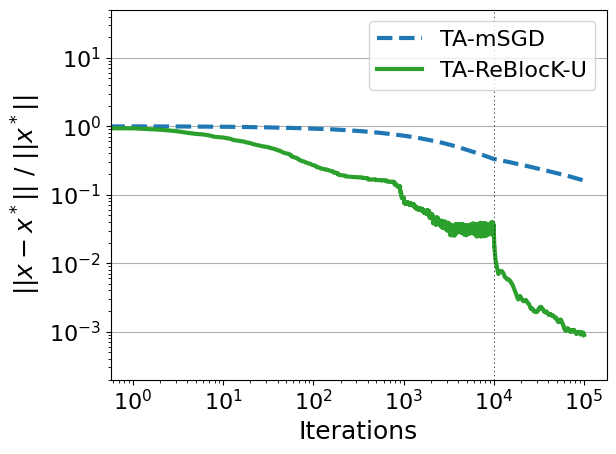

In [243]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls, color_map={"TA-ReBlocK-U": "tab:green"})
ax.set_ylim([2e-4, 5e1])

ax.legend(loc='upper right')
plt.savefig("reblock_succeed_fast.pdf", bbox_inches='tight')

# Test inconsistency on previous problem

In [64]:
k = 30
noise_level = 0.1
np.random.seed(0) 

In [65]:
y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [66]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:23<00:00, 379.44it/s]


In [67]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:39<00:00, 358.11it/s]


In [68]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:28<00:00, 372.16it/s]


In [69]:
np.savez('data/noise_0_1.npz', A=A, b=b, x_sgd=x_sgd, x_rbk=x_rbk, x_reblock=x_reblock)

In [244]:
data = np.load('data/noise_0_1.npz')
A = data['A']
b = data['b']
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
x_sgd = data['x_sgd']
x_rbk = data['x_rbk']
x_reblock = data['x_reblock']

In [246]:
x_data = [x_sgd, x_reblock]
labels = ['TA-mSGD', "TA-ReBlocK-U"]
styles = ['dashed', 'solid']
Tburn = 300

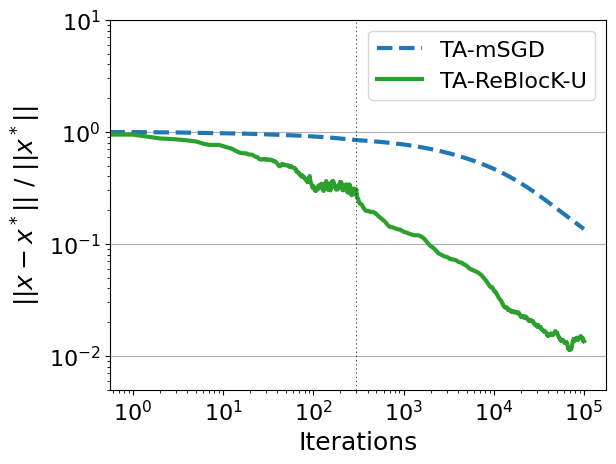

In [247]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls,color_map={"TA-ReBlocK-U": "tab:green"})
ax.legend(loc='upper right')
ax.set_ylim([5e-3, 1e1])
plt.savefig("noise_0_1.pdf", bbox_inches='tight')

In [91]:
noise_level = 0.001
np.random.seed(0) 

In [94]:
y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [95]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:57<00:00, 420.96it/s]


In [96]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:26<00:00, 374.76it/s]


In [97]:
np.savez('data/noise_0_001.npz', A=A, b=b, x_sgd=x_sgd, x_reblock=x_reblock)

In [248]:
data = np.load('data/noise_0_001.npz')
A = data['A']
b = data['b']
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
x_sgd = data['x_sgd']
x_reblock = data['x_reblock']

In [249]:
x_data = [x_sgd, x_reblock]
labels = ['TA-mSGD', "TA-ReBlocK-U"]
styles = ['dashed', 'solid']
Tburn = 10000

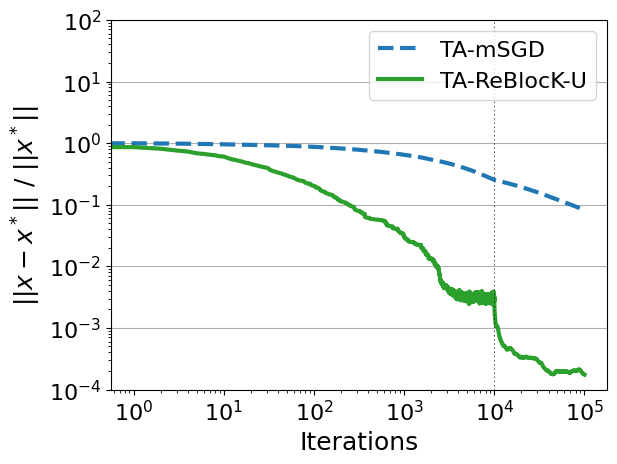

In [250]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_errs(zip(x_data, labels, styles), Tburn, A, b, x_ls, color_map={"TA-ReBlocK-U": "tab:green"})
ax.legend(loc='upper right')

ax.set_ylim([1e-4, 1e2])
plt.savefig("noise_0_001.pdf", bbox_inches='tight')